### LASSO parameter range experiments

We want to see whether smaller models (i.e. models with fewer nonzero features) tend to generalize to new cancer types better than larger ones; this script compares/visualizes those results.

In [1]:
import os
import itertools as it

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import pearsonr
import seaborn as sns

import pancancer_evaluation.config as cfg
import pancancer_evaluation.utilities.data_utilities as du
import pancancer_evaluation.utilities.analysis_utilities as au

%load_ext autoreload
%autoreload 2

In [2]:
base_results_dir = os.path.join(
    cfg.repo_root, '02_cancer_type_classification', 'results', 'lasso_range_lr_all_features'
)

training_dataset = 'all_other_cancers'
results_dir = os.path.join(base_results_dir, training_dataset)

plot_gene = 'ARID1A'
metric = 'aupr'
nz_cutoff = 5.0

output_plots = False
output_plots_dir = cfg.cancer_type_lasso_range_dir

### Get coefficient information for each lasso penalty

In [3]:
nz_coefs_df = []

# get coefficient info for training dataset specified above
for coef_info in au.generate_nonzero_coefficients_lasso_range(results_dir, gene=plot_gene):
    (gene,
     cancer_type,
     seed,
     lasso_param,
     coefs_list) = coef_info
    for fold_no, coefs in enumerate(coefs_list):
        nz_coefs_df.append(
            [gene, cancer_type, lasso_param, seed, fold_no, len(coefs)]
        )
        
nz_coefs_df = pd.DataFrame(
    nz_coefs_df,
    columns=['gene', 'cancer_type', 'lasso_param', 'seed', 'fold', 'nz_coefs']
)
nz_coefs_df.lasso_param = nz_coefs_df.lasso_param.astype(float)
nz_coefs_df = nz_coefs_df[nz_coefs_df.gene == plot_gene].copy()
nz_coefs_df.head()

,gene,cancer_type,lasso_param,seed,fold,nz_coefs
0,ARID1A,UCEC,1000.0,42,0,12958
1,ARID1A,UCEC,1000.0,42,1,12758
2,ARID1A,UCEC,1000.0,42,2,12936
3,ARID1A,UCEC,1000.0,42,3,12818
4,ARID1A,COAD,750.0,42,0,10976


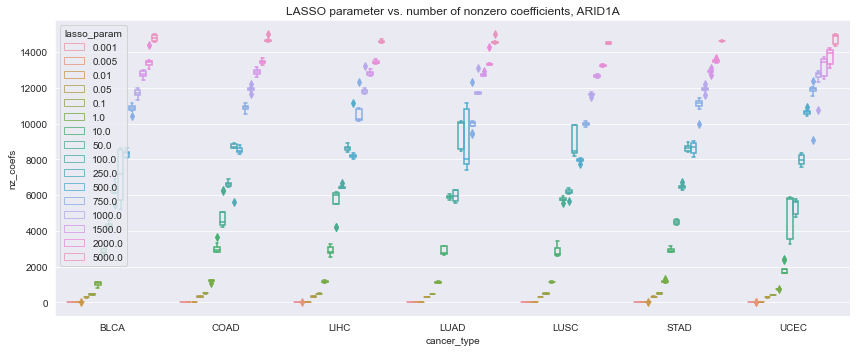

In [4]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=nz_coefs_df.sort_values(by=['cancer_type', 'lasso_param']),
    x='cancer_type', y='nz_coefs', hue='lasso_param'
)

# color the boxplot lines/edges rather than the box fill
# this makes it easier to discern colors at the extremes; i.e. very many or few nonzero coefs
# https://stackoverflow.com/a/72333641
ax = plt.gca()
box_patches = [patch for patch in ax.patches if type(patch) == matplotlib.patches.PathPatch]
num_patches = len(box_patches)
lines_per_boxplot = len(ax.lines) // num_patches
for i, patch in enumerate(box_patches):
    # set the linecolor on the patch to the facecolor, and set the facecolor to None
    col = patch.get_facecolor()
    patch.set_edgecolor(col)
    patch.set_facecolor('None')

    # each box has associated Line2D objects (to make the whiskers, fliers, etc.)
    # loop over them here, and use the same color as above
    for line in ax.lines[i * lines_per_boxplot: (i + 1) * lines_per_boxplot]:
        line.set_color(col)
        line.set_mfc(col)  # facecolor of fliers
        line.set_mec(col)  # edgecolor of fliers

# also fix the legend to color the edges rather than fill
for legpatch in ax.legend_.get_patches():
    col = legpatch.get_facecolor()
    legpatch.set_edgecolor(col)
    legpatch.set_facecolor('None')

plt.title(f'LASSO parameter vs. number of nonzero coefficients, {plot_gene}')
plt.tight_layout()

### Get performance information for each lasso penalty

In [5]:
perf_df = au.load_prediction_results_lasso_range(results_dir,
                                                 training_dataset,
                                                 gene=plot_gene)
perf_df = perf_df[perf_df.gene == plot_gene].copy()
perf_df.head()

,auroc,aupr,gene,holdout_cancer_type,signal,seed,data_type,fold,experiment,lasso_param
0,1.00000,1.000000,ARID1A,LIHC,signal,42,train,0,all_other_cancers,1000.0
1,0.56234,0.150100,ARID1A,LIHC,signal,42,test,0,all_other_cancers,1000.0
2,0.76887,0.365340,ARID1A,LIHC,signal,42,cv,0,all_other_cancers,1000.0
3,1.00000,1.000000,ARID1A,LIHC,signal,42,train,1,all_other_cancers,1000.0
4,0.42563,0.086198,ARID1A,LIHC,signal,42,test,1,all_other_cancers,1000.0


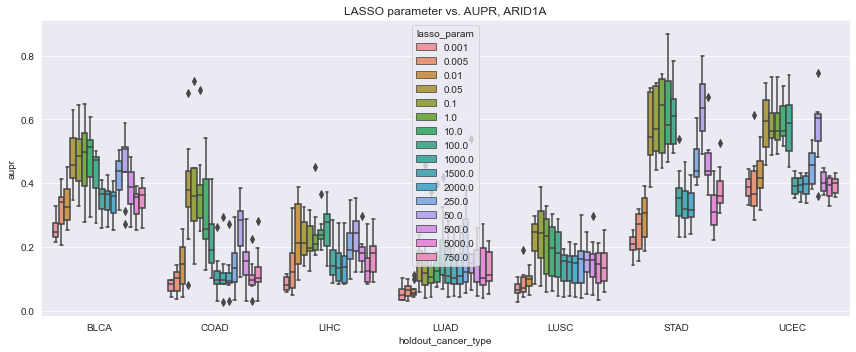

In [6]:
sns.set({'figure.figsize': (12, 5)})

sns.boxplot(
    data=(
        perf_df[(perf_df.signal == 'signal') &
                (perf_df.data_type == 'test')]
          .sort_values(by=['holdout_cancer_type', 'lasso_param'])
    ), x='holdout_cancer_type', y=metric, hue='lasso_param'
)
plt.title(f'LASSO parameter vs. {metric.upper()}, {plot_gene}')
plt.tight_layout()

if output_plots:
    output_plots_dir.mkdir(exist_ok=True)
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_boxes.png',
                dpi=200, bbox_inches='tight')

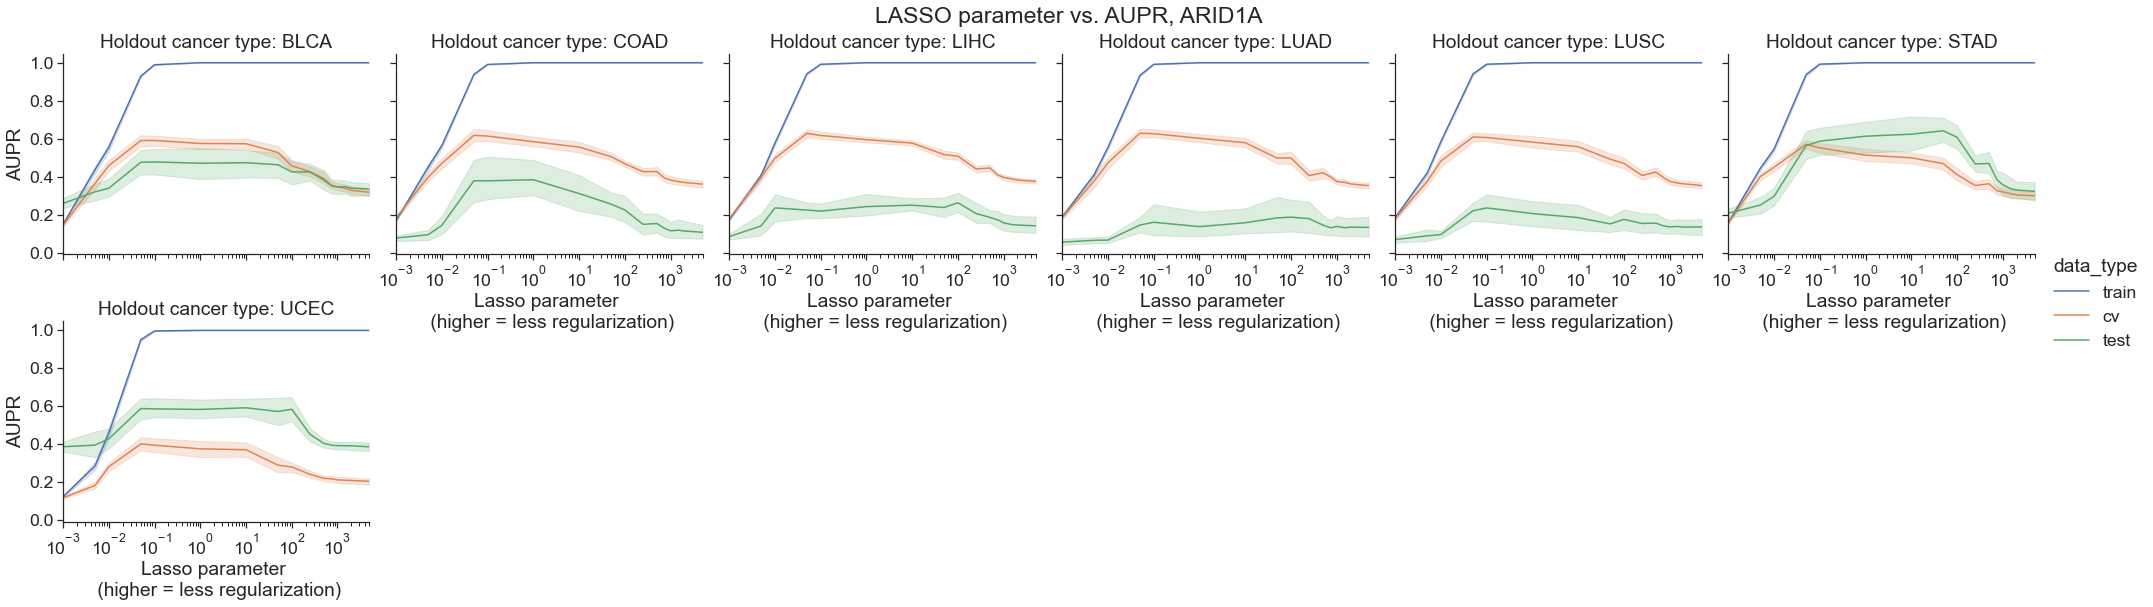

In [7]:
# try with a float-valued x-axis
# this is probably more "correct" than treating each lasso parameter as a
# category (above plot); here the spaces between parameters reflect their
# actual real-valued distance in log-space
# sns.set({'figure.figsize': (12, 5)})
sns.set_style('ticks')

plot_df = (
    perf_df[(perf_df.signal == 'signal')]
      .sort_values(by=['holdout_cancer_type', 'lasso_param'])
      .reset_index(drop=True)
)
plot_df.lasso_param = plot_df.lasso_param.astype(float)

with sns.plotting_context('notebook', font_scale=1.6):
    g = sns.relplot(
        data=plot_df,
        x='lasso_param', y=metric, hue='data_type',
        hue_order=['train', 'cv', 'test'],
        kind='line', col='holdout_cancer_type',
        col_wrap=6, height=4, aspect=1.2
    )
    g.set(xscale='log', xlim=(min(plot_df.lasso_param), max(plot_df.lasso_param)))
    g.set_titles('Holdout cancer type: {col_name}')
    g.set_xlabels('Lasso parameter \n (higher = less regularization)')
    g.set_ylabels(f'{metric.upper()}')
    plt.suptitle(f'LASSO parameter vs. {metric.upper()}, {plot_gene}', y=1.01)

if output_plots:
    plt.savefig(output_plots_dir / f'{plot_gene}_lasso_facets.png',
                dpi=200, bbox_inches='tight')

### Compare feature selection with performance

TODO: this needs to be documented

In [8]:
# get parameters with top 25% of validation performance
cancer_type = 'BLCA'
top_df = (
    perf_df[(perf_df.data_type == 'cv') &
            (perf_df.signal == 'signal') &
            (perf_df.holdout_cancer_type == cancer_type)]
      .groupby(['lasso_param'])
      .agg(np.mean)
      .drop(columns=['seed', 'fold'])
      .rename(columns={'auroc': 'mean_auroc', 'aupr': 'mean_aupr'})
      .sort_values(by='mean_aupr', ascending=False)
)
top_df.index = top_df.index.astype(float)
top_df.head(10)

,mean_auroc,mean_aupr
lasso_param,,
0.100,0.829964,0.590499
0.050,0.830256,0.589809
1.000,0.831340,0.574566
10.000,0.835997,0.573086
50.000,0.827468,0.527168
0.010,0.781454,0.457864
100.000,0.815497,0.456600
250.000,0.805516,0.426666
500.000,0.796776,0.390010


In [9]:
top_df['aupr_rank'] = top_df.mean_aupr.rank(ascending=False)
top_5_lasso = top_df.loc[top_df.aupr_rank <= 5, :].index

top_5_lasso

Float64Index([0.1, 0.05, 1.0, 10.0, 50.0], dtype='float64', name='lasso_param')

In [10]:
# get parameter with best validation performance
top_lasso_param = top_5_lasso[0]

# get parameter in top 5 validation performance with least nonzero coefficients
smallest_lasso_param = (
    nz_coefs_df[(nz_coefs_df.cancer_type == cancer_type) &
                (nz_coefs_df.lasso_param.isin(top_lasso))]
      .groupby(['lasso_param'])
      .agg(np.mean)
      .drop(columns=['seed', 'fold'])
      .sort_values(by='nz_coefs', ascending=True)
).index[0]

print(smallest_lasso_param, top_lasso_param)

NameError: name 'top_lasso' is not defined

In [ ]:
# compare performance
compare_df = top_df.loc[
    [smallest_lasso_param, top_lasso_param], :
]
compare_df['desc'] = ['smallest', 'best']
compare_df